In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import pickle
import matplotlib
import matplotlib.pyplot as plt
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_score, recall_score
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.feature_selection import SelectFromModel
from sklearn.utils.class_weight import compute_class_weight
import itertools
from IPython.display import display

%matplotlib inline

In [2]:
x_train = pd.read_csv('data/s2e/audio_train.csv')
x_test = pd.read_csv('data/s2e/audio_test.csv')

print(x_train.shape)
y_train = x_train['label']
y_test = x_test['label']

print(x_train.head())
print(x_test.head())

(1609, 11)
   Unnamed: 0                wav_file  label  sig_mean   sig_std  rmse_mean  \
0        1878  Ses01M_script01_1_F001      4  0.009999  0.020444   0.010524   
1         799     Ses01M_impro04_F000      5  0.023398  0.035891   0.023701   
2        1281  Ses01M_script02_2_M030      5  0.010737  0.015038   0.010873   
3        1864     Ses01F_impro03_M018      4  0.012538  0.017292   0.012596   
4        1404  Ses01F_script03_1_F002      3  0.029876  0.042971   0.030287   

   rmse_std   silence  harmonic  auto_corr_max  auto_corr_std  
0  0.041555  0.187024  0.170947       0.000946       0.000496  
1  0.062428  0.838446  0.170724       0.002276       0.003044  
2  0.026170  0.349626  0.171640       0.000500       0.000646  
3  0.029441  0.600622  0.172823       0.000621       0.000938  
4  0.070738  0.587978  0.171083       0.003049       0.003095  
   Unnamed: 0                wav_file  label  sig_mean   sig_std  rmse_mean  \
0         184     Ses01F_impro05_F028      0  0.012

In [3]:
print(x_train.shape, x_test.shape)
cl_weight = dict(pd.Series(x_train['label']).value_counts(normalize=True))
print(dict(pd.Series(x_train['label']).value_counts()))

del x_train['label']
del x_test['label']
del x_train['wav_file']
del x_test['wav_file']

(1609, 11) (403, 11)
{2: 369, 5: 318, 3: 293, 1: 227, 4: 218, 0: 184}


In [4]:
emotion_dict = {'ang': 0,
                'hap': 1,
                'sad': 2,
                'fea': 3,
                'sur': 4,
                'neu': 5}

emo_keys = list(['ang', 'hap', 'sad', 'fea', 'sur', 'neu'])

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(8,8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def one_hot_encoder(true_labels, num_records, num_classes):
    temp = np.array(true_labels[:num_records])
    true_labels = np.zeros((num_records, num_classes))
    true_labels[np.arange(num_records), temp] = 1
    return true_labels

def display_results(y_test, pred_probs, cm=True):
    pred = np.argmax(pred_probs, axis=-1)
    one_hot_true = one_hot_encoder(y_test, len(pred), len(emotion_dict))
    print('Test Set Accuracy =  {0:.3f}'.format(accuracy_score(y_test, pred)))
    print('Test Set F-score =  {0:.3f}'.format(f1_score(y_test, pred, average='macro')))
    print('Test Set Precision =  {0:.3f}'.format(precision_score(y_test, pred, average='macro')))
    print('Test Set Recall =  {0:.3f}'.format(recall_score(y_test, pred, average='macro')))
    if cm:
        plot_confusion_matrix(confusion_matrix(y_test, pred), classes=emo_keys)

Test Set Accuracy =  0.690
Test Set F-score =  0.692
Test Set Precision =  0.702
Test Set Recall =  0.685
Confusion matrix, without normalization
[[25  6 10  0  0  4]
 [ 4 27 15  0  0  5]
 [ 6 14 62  0  0 23]
 [ 0  1  4 74  0  0]
 [ 0  0  1  0 55  1]
 [ 2 10 19  0  0 35]]


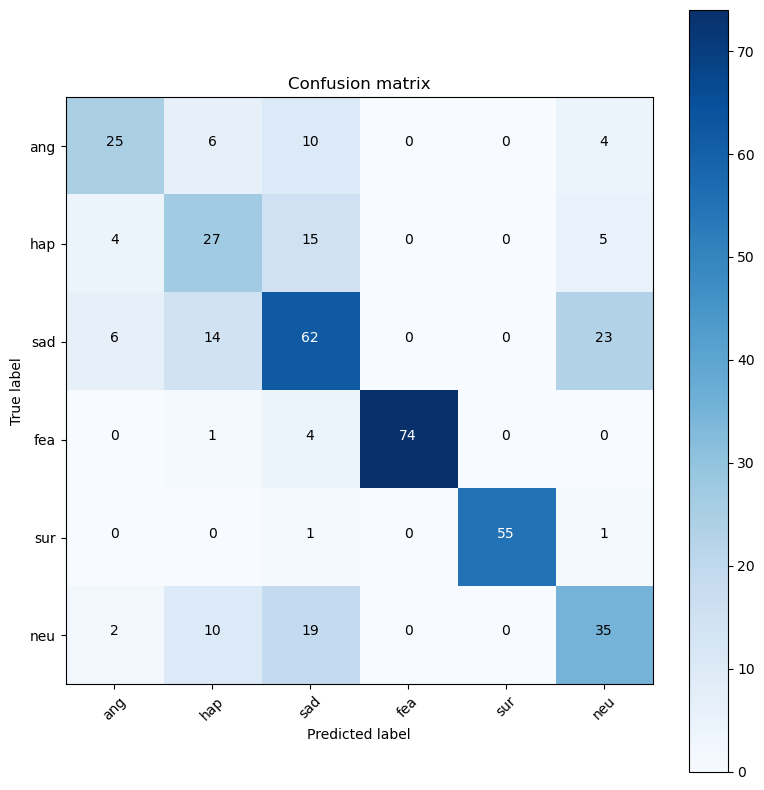

In [5]:
rf_classifier = RandomForestClassifier(n_estimators=1200, min_samples_split=25)
rf_classifier.fit(x_train, y_train)

# Predict
pred_probs = rf_classifier.predict_proba(x_test)

# Results
display_results(y_test, pred_probs)

with open('pred_probas/rf_classifier.pkl', 'wb') as f:
    pickle.dump(pred_probs, f)

c:\Users\Unity_Comp\anaconda3\envs\cudaRun\lib\site-packages\xgboost\training.py:183: UserWarning: [09:06:34] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "sub_sample" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Test Set Accuracy =  0.774
Test Set F-score =  0.779
Test Set Precision =  0.791
Test Set Recall =  0.772
Confusion matrix, without normalization
[[27  0 13  0  1  4]
 [ 0 40  6  0  0  5]
 [ 6  1 73  0  2 23]
 [ 0  4  1 74  0  0]
 [ 0  1  1  0 55  0]
 [ 1  6 16  0  0 43]]


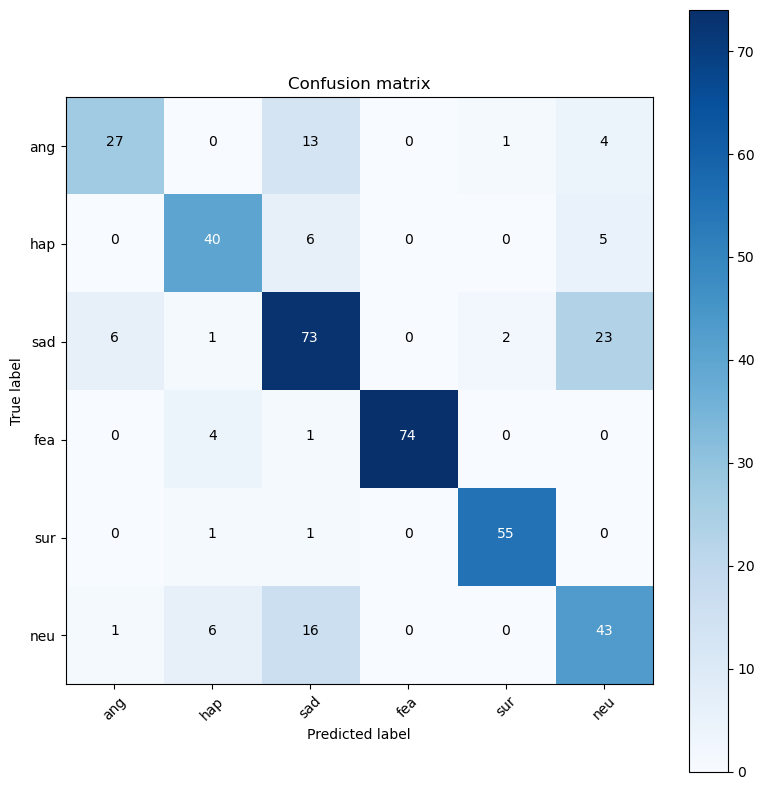

In [6]:
xgb_classifier = xgb.XGBClassifier(max_depth=7, learning_rate=0.008, objective='multi:softprob', 
                                   n_estimators=1200, sub_sample=0.8, num_class=len(emotion_dict),
                                   booster='gbtree', n_jobs=4)
xgb_classifier.fit(x_train, y_train)

# Predict
pred_probs = xgb_classifier.predict_proba(x_test)

# Results
display_results(y_test, pred_probs)

with open('pred_probas/xgb_classifier.pkl', 'wb') as f:
    pickle.dump(pred_probs, f)

Test Set Accuracy =  0.422
Test Set F-score =  0.321
Test Set Precision =  0.398
Test Set Recall =  0.381
Confusion matrix, without normalization
[[ 4  4 27  2  6  2]
 [ 5  3 28  8  4  3]
 [ 1  2 79 12  0 11]
 [ 0  0  3  8 68  0]
 [ 0  0  2  0 55  0]
 [ 0  0 41  4  0 21]]


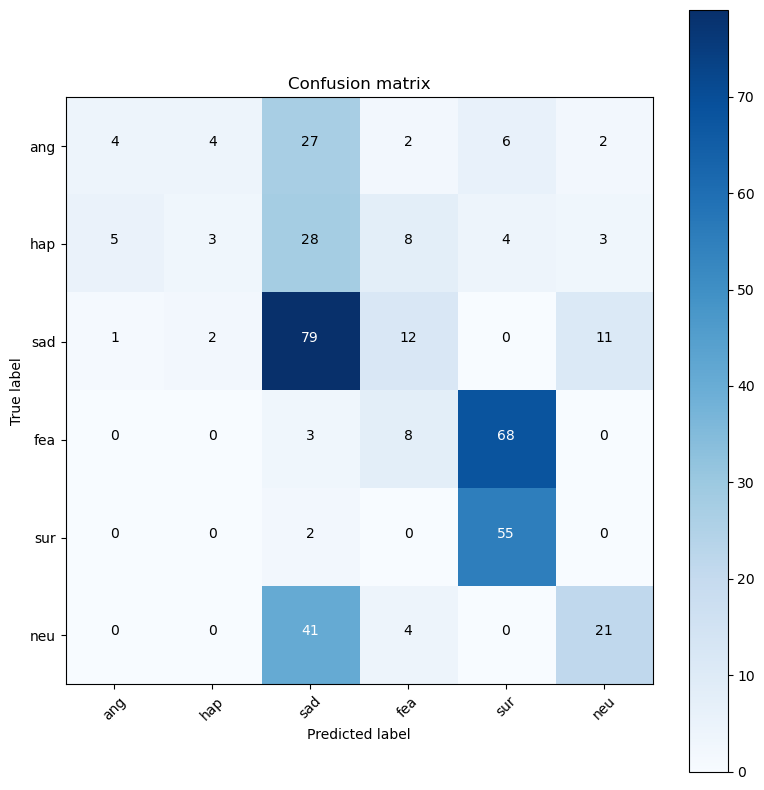

In [7]:
mlp_classifier = MLPClassifier(hidden_layer_sizes=(650, ), activation='relu', solver='adam', alpha=0.0001,
                               batch_size='auto', learning_rate='adaptive', learning_rate_init=0.01,
                               power_t=0.5, max_iter=1000, shuffle=True, random_state=None, tol=0.0001,
                               verbose=False, warm_start=True, momentum=0.8, nesterovs_momentum=True,
                               early_stopping=False, validation_fraction=0.1, beta_1=0.9, beta_2=0.999,
                               epsilon=1e-08)

mlp_classifier.fit(x_train, y_train)

# Predict
pred_probs = mlp_classifier.predict_proba(x_test)

# Results
display_results(y_test, pred_probs)

with open('pred_probas/mlp_classifier.pkl', 'wb') as f:
    pickle.dump(pred_probs, f)

Test Set Accuracy =  0.422
Test Set F-score =  0.321
Test Set Precision =  0.398
Test Set Recall =  0.381
Confusion matrix, without normalization
[[ 4  4 27  2  6  2]
 [ 5  3 28  8  4  3]
 [ 1  2 79 12  0 11]
 [ 0  0  3  8 68  0]
 [ 0  0  2  0 55  0]
 [ 0  0 41  4  0 21]]


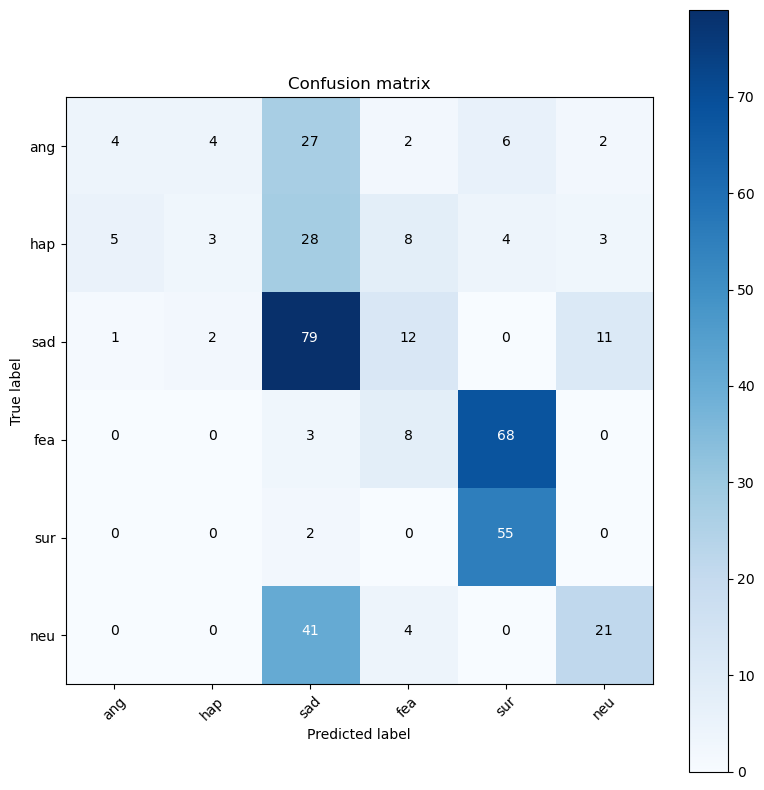

In [8]:
svc_classifier = LinearSVC()

svc_classifier.fit(x_train, y_train)

# Predict
pred = svc_classifier.predict(x_test)

# Results
display_results(y_test, pred_probs)

with open('pred_probas/svc_classifier_model.pkl', 'wb') as f:
    pickle.dump(svc_classifier, f)

Test Set Accuracy =  0.367
Test Set F-score =  0.233
Test Set Precision =  0.269
Test Set Recall =  0.292
Confusion matrix, without normalization
[[ 9  3 31  2  0  0]
 [ 9  4 35  3  0  0]
 [ 5  1 76 21  0  2]
 [ 0  0 20 59  0  0]
 [ 3  0 16 38  0  0]
 [ 1  0 59  6  0  0]]


c:\Users\Unity_Comp\anaconda3\envs\cudaRun\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


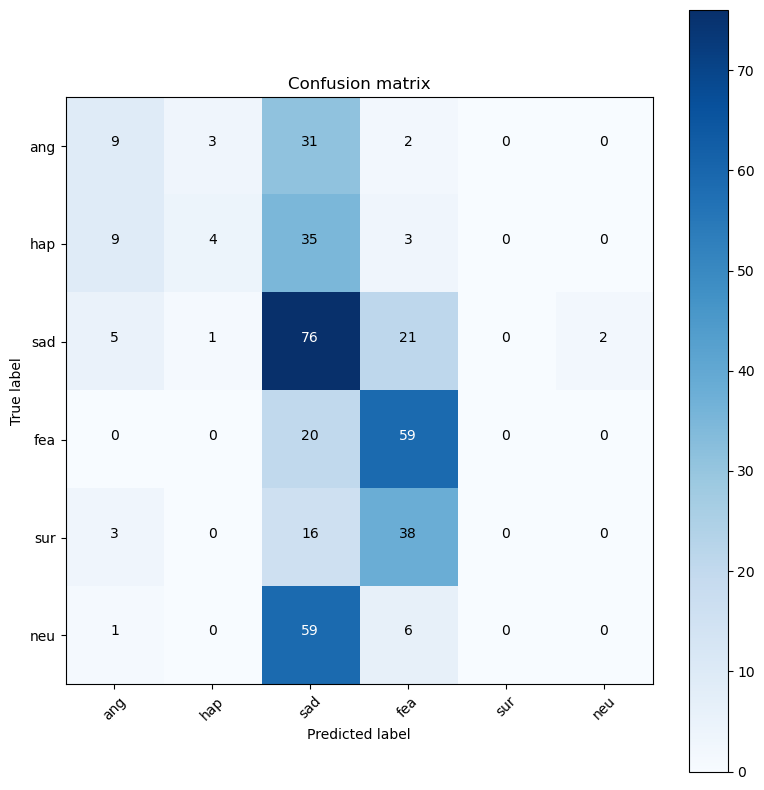

In [9]:
mnb_classifier = MultinomialNB()

mnb_classifier.fit(x_train, y_train)

# Predict
pred_probs = mnb_classifier.predict_proba(x_test)

# Results
display_results(y_test, pred_probs)

with open('pred_probas/mnb_classifier.pkl', 'wb') as f:
    pickle.dump(pred_probs, f)

c:\Users\Unity_Comp\anaconda3\envs\cudaRun\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\Unity_Comp\anaconda3\envs\cudaRun\lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Test Set Accuracy =  0.568
Test Set F-score =  0.541
Test Set Precision =  0.548
Test Set Recall =  0.548
Confusion matrix, without normalization
[[22  9 10  3  0  1]
 [11  7 20  6  0  7]
 [ 5  4 57  3  0 36]
 [ 0  0  3 64 12  0]
 [ 1  0  1  8 47  0]
 [ 2  3 27  2  0 32]]


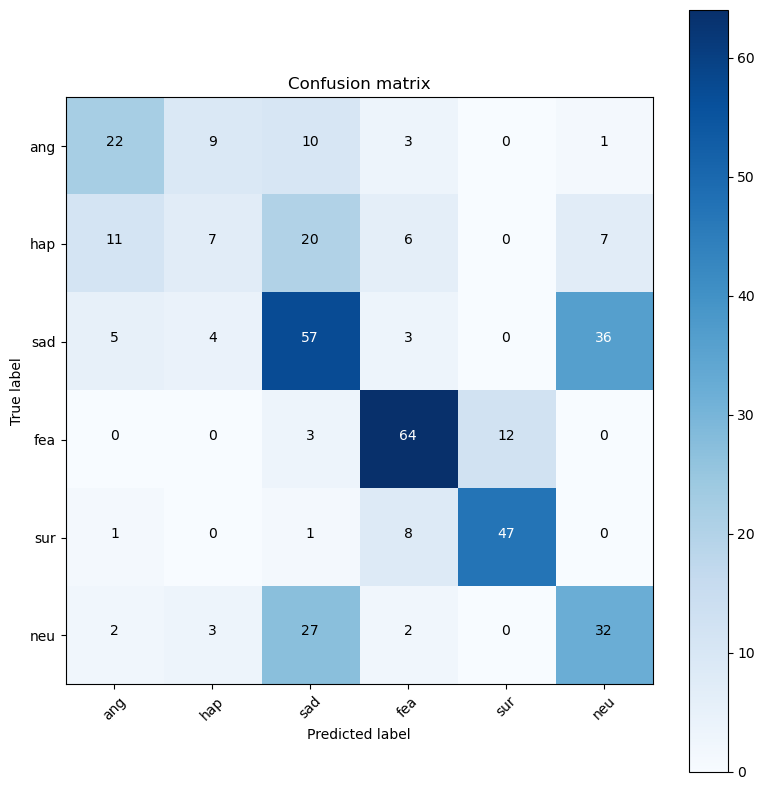

In [10]:
lr_classifier = LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=1000)

lr_classifier.fit(x_train, y_train)

# Predict
pred_probs = lr_classifier.predict_proba(x_test)

# Results
display_results(y_test, pred_probs)

with open('pred_probas/lr_classifier.pkl', 'wb') as f:
    pickle.dump(pred_probs, f)

[0.33346608 0.09101682 0.06165406 0.07057277 0.1378406  0.0567409
 0.04569646 0.1417502  0.06126213]


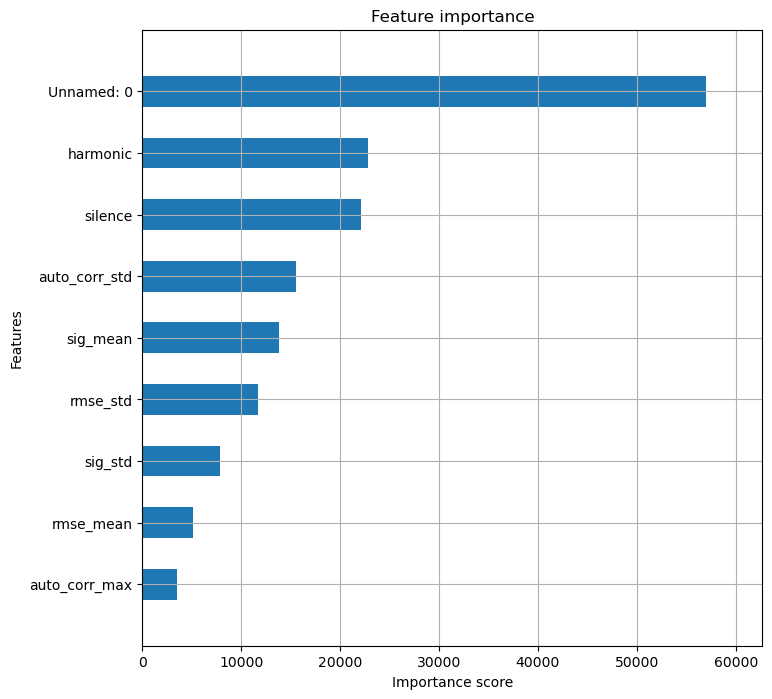

In [11]:
print(xgb_classifier.feature_importances_)


# Plot feature importance dengan parameter yang diinginkan
ax = xgb.plot_importance(
    xgb_classifier,
    max_num_features=10,
    height=0.5,
    show_values=False
)

# Atur ukuran figure agar lebih proporsional
fig = ax.figure
fig.set_size_inches(8, 8)

# Tampilkan plot (jika belum otomatis tampil)
plt.show()

In [12]:
contribution_scores = xgb_classifier.feature_importances_
contribution_scores

array([0.33346608, 0.09101682, 0.06165406, 0.07057277, 0.1378406 ,
       0.0567409 , 0.04569646, 0.1417502 , 0.06126213], dtype=float32)

In [13]:
import numpy as np
import xgboost as xgb

top_n = [3, 5, 6, 7, 8]  # jumlah fitur teratas yang ingin dipilih

# Pastikan model sudah dilatih
xgb_classifier.fit(x_train, y_train)

# Ambil skor kontribusi fitur
contribution_scores = xgb_classifier.feature_importances_

for n in top_n:
    # Tentukan threshold berdasarkan skor kontribusi fitur teratas
    threshold = np.sort(contribution_scores)[::-1][n-1]
    print(f'Stats for top {n} features:')

    # Pilih indeks fitur yang memiliki skor >= threshold
    selected_features_idx = np.where(contribution_scores >= threshold)[0]

    # Pilih kolom fitur dari DataFrame (asumsi x_train dan x_test adalah DataFrame)
    select_x_train = x_train.iloc[:, selected_features_idx]
    select_x_test = x_test.iloc[:, selected_features_idx]

    # Buat dan latih model XGBoost baru dengan fitur terpilih
    select_xgb_classifier = xgb.XGBClassifier(max_depth=7, learning_rate=0.008, objective='multi:softprob', 
                                              n_estimators=1200, subsample=0.8, num_class=len(emotion_dict),
                                              booster='gbtree', n_jobs=4)
    select_xgb_classifier.fit(select_x_train, y_train)

    # Prediksi probabilitas pada data uji
    pred_probs = select_xgb_classifier.predict_proba(select_x_test)

    # Tampilkan hasil evaluasi tanpa confusion matrix
    display_results(y_test, pred_probs, cm=False)


c:\Users\Unity_Comp\anaconda3\envs\cudaRun\lib\site-packages\xgboost\training.py:183: UserWarning: [09:06:43] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "sub_sample" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Stats for top 3 features:
Test Set Accuracy =  0.804
Test Set F-score =  0.814
Test Set Precision =  0.827
Test Set Recall =  0.804
Stats for top 5 features:
Test Set Accuracy =  0.794
Test Set F-score =  0.801
Test Set Precision =  0.809
Test Set Recall =  0.795
Stats for top 6 features:
Test Set Accuracy =  0.797
Test Set F-score =  0.805
Test Set Precision =  0.813
Test Set Recall =  0.799
Stats for top 7 features:
Test Set Accuracy =  0.799
Test Set F-score =  0.809
Test Set Precision =  0.817
Test Set Recall =  0.804
Stats for top 8 features:
Test Set Accuracy =  0.794
Test Set F-score =  0.803
Test Set Precision =  0.815
Test Set Recall =  0.795


Test Set Accuracy =  0.777
Test Set F-score =  0.780
Test Set Precision =  0.803
Test Set Recall =  0.766
Confusion matrix, without normalization
[[27  0 14  0  1  3]
 [ 0 37  8  0  0  6]
 [ 5  1 80  0  0 19]
 [ 0  3  2 74  0  0]
 [ 0  1  1  0 55  0]
 [ 1  5 20  0  0 40]]


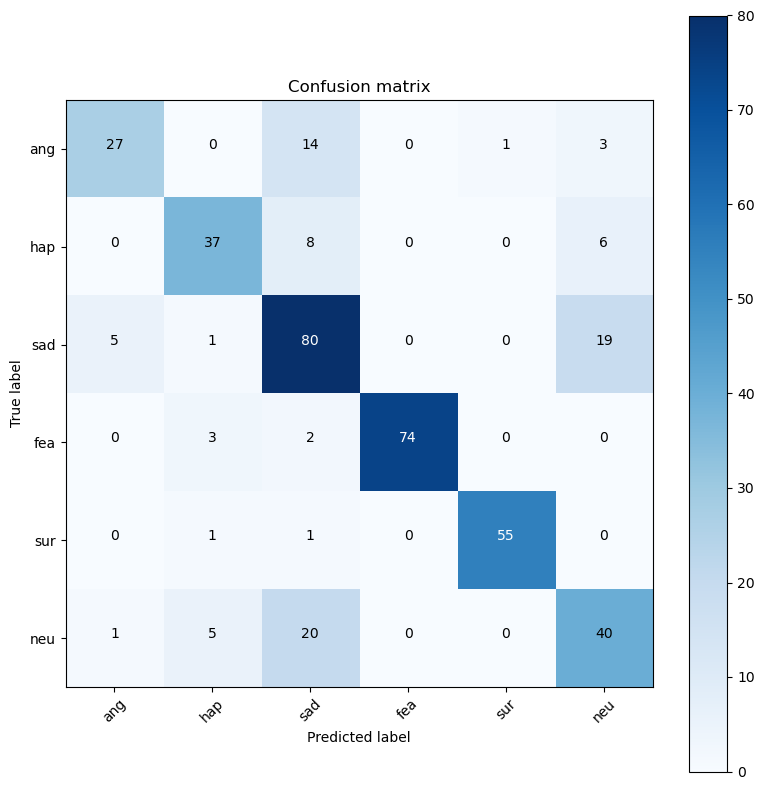

In [14]:
# Load predicted probabilities
with open('pred_probas\\rf_classifier.pkl', 'rb') as f:
    rf_pred_probs = pickle.load(f)

with open('pred_probas/xgb_classifier.pkl', 'rb') as f:
    xgb_pred_probs = pickle.load(f)
    
with open('pred_probas/svc_classifier_model.pkl', 'rb') as f:
    svc_preds = pickle.load(f)
    
with open('pred_probas/mnb_classifier.pkl', 'rb') as f:
    mnb_pred_probs = pickle.load(f)
    
with open('pred_probas/mlp_classifier.pkl', 'rb') as f:
    mlp_pred_probs = pickle.load(f)
    
with open('pred_probas/lr_classifier.pkl', 'rb') as f:
    lr_pred_probs = pickle.load(f)

# with open('pred_probas/lstm_classifier.pkl', 'rb') as f:
#     lstm_pred_probs = pickle.load(f)

# Average of the predicted probabilites
ensemble_pred_probs = (xgb_pred_probs +
                       mlp_pred_probs +
                       rf_pred_probs)/3.0
# Show metrics
display_results(y_test, ensemble_pred_probs)